In [1]:
!pip install transformers
!pip install shap
!pip install spicy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 22.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import transformers
import shap
import spicy as sp
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.utils import data
from sklearn import metrics
import torch.nn as nn
import pandas as pd
import numpy as np
import argparse
import logging
import random
import torch
import sys
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
PREDICTION_COLUMN = 'Сознательность_3'
model_path = '/content/drive/MyDrive/big_5/OCEAN_shap_texts_bert/simple_bert_Сознательность_3_70651.bin'

dataset = pd.read_csv('/content/drive/MyDrive/big_5/df_texts_ocean.csv')
dataset['lengths'] = dataset.post_text.apply(lambda x: len(str(x).split()))
dataset = dataset.query('30 > lengths > 15')
data = pd.DataFrame({'text':dataset['post_text_preprocessed'],'target':dataset[PREDICTION_COLUMN]})
data = data.query('target in [0,2]').sample(5000)
data.head()

,text,target
76771,в моей затрапезной PUNK заштатной провинции ос...,2
1798,пройдут года PUNK поймет любой PUNK и это не и...,2
90744,с тобой хотят PUNK PUNK PUNK хочешь узнать что...,0
204415,прожив NUM лет в россии американец так и не по...,0
240837,ура PUNK у нас снова всё получилось PUNK мы во...,2


In [6]:
data.target.value_counts()

0    2589
2    2411
Name: target, dtype: int64

In [7]:
len(data)

5000

In [8]:
class Bert_sequence_classifcation(nn.Module):
    def __init__(self, model_name, num_classes):
        super(Bert_sequence_classifcation, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_classes)

    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        logits = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask, return_dict=True).logits 
        return logits

In [9]:
 # load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('xlm-roberta-base')
model = Bert_sequence_classifcation('xlm-roberta-base', 3).to(device)
model.load_state_dict(torch.load(model_path))   #,map_location=torch.device('cpu')))
labels = sorted(model.bert.config.label2id, key=model.bert.config.label2id.get)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [10]:
def f(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x], device=device)
    # print(tv)
    attention_mask = (tv != 0).type(torch.int64)
    # print(attention_mask)
    outputs = model(tv, attention_mask).detach().cpu()
    outputs = torch.log_softmax(outputs, dim=1).numpy()
    # print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [11]:
def predict(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x], device=device)
    # print(tv)
    attention_mask = (tv != 0).type(torch.int64).to(device)
    # print(attention_mask)
    outputs = model(tv, attention_mask).detach().cpu()
    res = torch.log_softmax(outputs, dim=1).argmax(dim=1)
    return res

In [12]:
predict(['приветик','еще раз привет'])

tensor([0, 2])

In [13]:
texts = list(data.text)
targets = list(data.target)

def chunkify(texts, targets, n):

  texts_splited = [texts[i::n] for i in range(n)]
  targets_splited = [targets[i::n] for i in range(n)]

  return texts_splited, targets_splited

texts_splited, targets_splited =chunkify(texts, targets, 50)

In [14]:
len(texts_splited[0])

100

In [15]:
from tqdm.auto import tqdm

In [16]:
predictions = []
for text in tqdm(texts_splited):
  predictions.append(predict(text))

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
list_predictions = []
for i in predictions:
  for x in list(i):
    list_predictions.append(int(x))

In [18]:
len(list_predictions)

5000

In [19]:
data['predictions'] = list_predictions
data.head()

,text,target,predictions
76771,в моей затрапезной PUNK заштатной провинции ос...,2,0
1798,пройдут года PUNK поймет любой PUNK и это не и...,2,0
90744,с тобой хотят PUNK PUNK PUNK хочешь узнать что...,0,0
204415,прожив NUM лет в россии американец так и не по...,0,2
240837,ура PUNK у нас снова всё получилось PUNK мы во...,2,0


In [20]:
polar_people = data.query('target == predictions')
polar_people

,text,target,predictions
90744,с тобой хотят PUNK PUNK PUNK хочешь узнать что...,0,0
234037,спасибо всем за поздравления PUNK что окружили...,0,0
61465,милые девушки PUNK на почте PUNK если интересн...,2,2
234700,со старым новым годом всех EMOJI PUNK пусть ст...,0,0
216436,вдохновение PUNK безумно горжусь и радуюсь ка...,0,0
...,...,...,...
231944,PUNK иногда люди не хотят слышать правду PUNK...,0,0
246566,звонок в дверь PUNK PUNK здравствуте тётя сара...,0,0
102874,люди PUNK берегите себя PUNK пожалуйста PUNK P...,0,0
233327,белорукий гиббон PUNK обитает от юго PUNK запа...,0,0


In [21]:
import shap
explainer = shap.Explainer(f, tokenizer, output_names=labels)

In [22]:
texts = list(polar_people.text)
shap_values = explainer(texts)

Partition explainer:   8%|▊         | 115/1533 [05:49<1:13:30,  3.11s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (3115 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 297/1533 [15:34<1:04:59,  3.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 604/1533 [31:57<48:51,  3.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 1082/1533 [56:55<23:13,  3.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 1534it [1:20:35,  3.16s/it]


In [23]:
shap.plots.text(shap_values[:10])

Output hidden; open in https://colab.research.google.com to view.

In [24]:
shap.plots.text(shap_values[10:20])

Output hidden; open in https://colab.research.google.com to view.

In [25]:
shap.plots.text(shap_values[20:30])

Output hidden; open in https://colab.research.google.com to view.

In [26]:
shap.plots.text(shap_values[30:40])

In [27]:
shap.plots.text(shap_values[40:50])

In [28]:
shap.plots.text(shap_values[50:60])

In [29]:
shap.plots.text(shap_values[60:70])

In [30]:
shap.plots.text(shap_values[70:80])

In [31]:
shap.plots.text(shap_values[80:90])

In [32]:
shap.plots.text(shap_values[90:100])

In [33]:
shap.plots.text(shap_values[100:120])

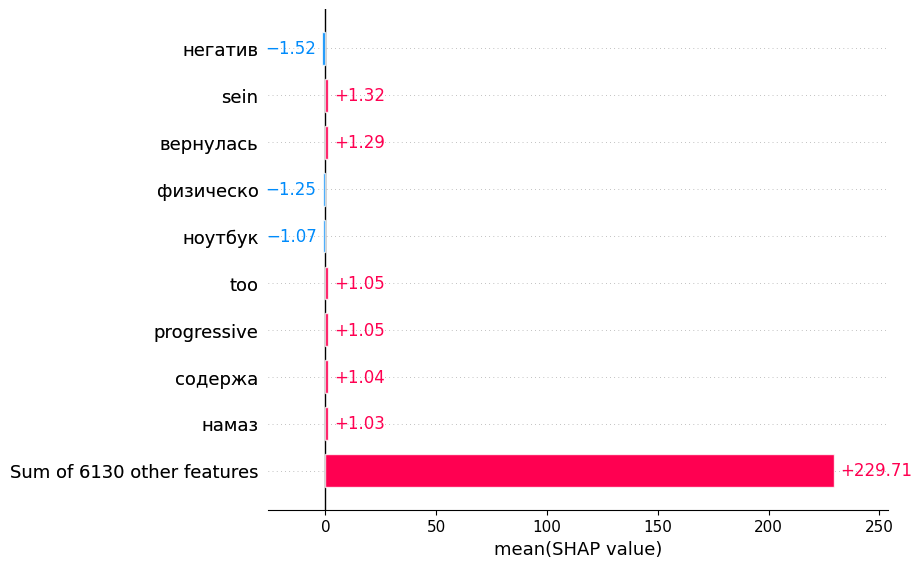

In [34]:
shap.plots.bar(shap_values[:,:,0].mean(0)) # по классу 0

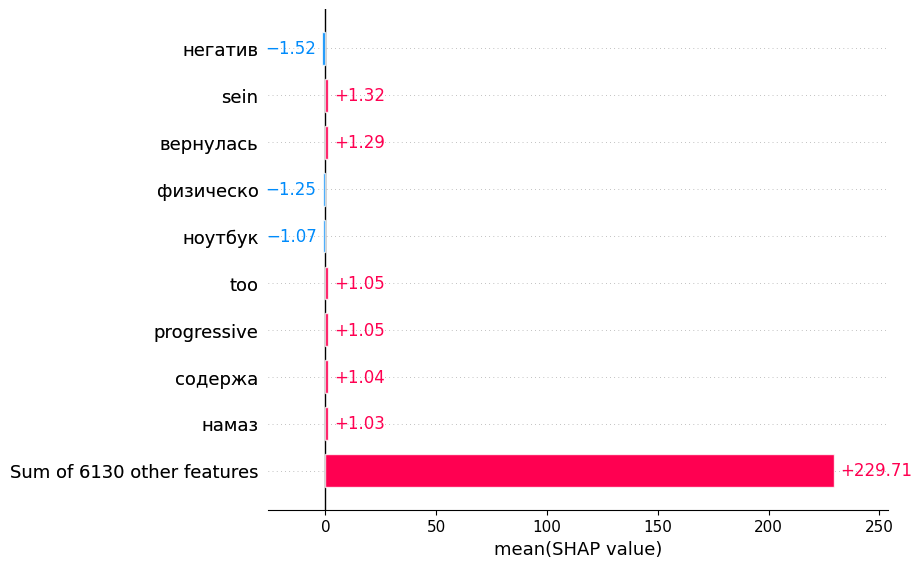

In [35]:
shap.plots.bar(shap_values[:,:,0].mean(0)) 

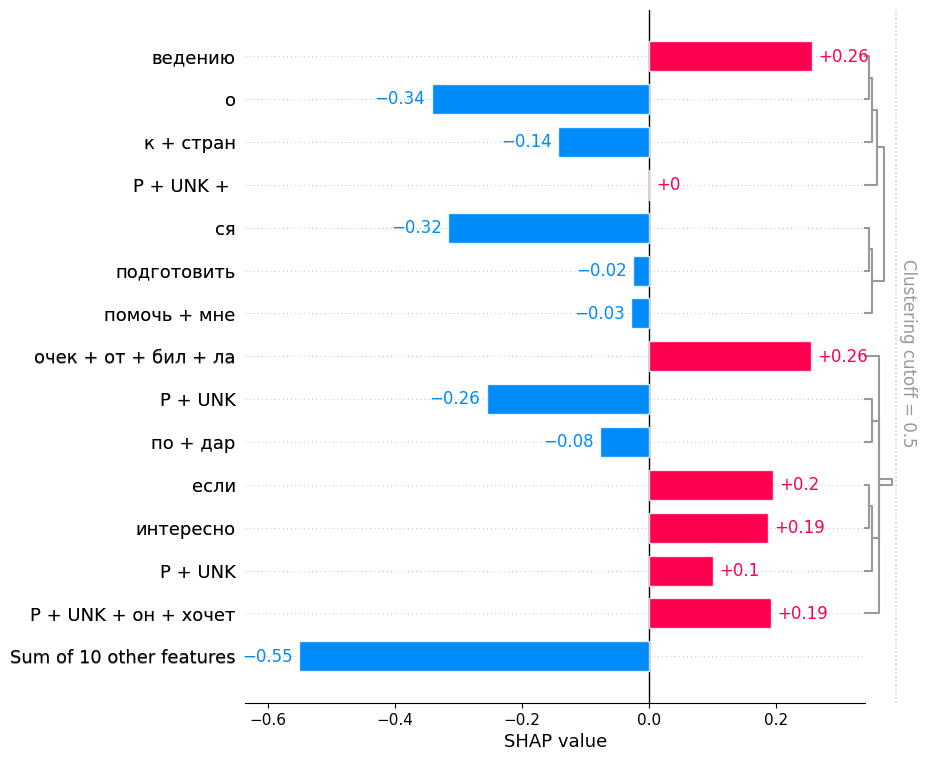

In [36]:
shap.plots.bar(shap_values[2,:, 2], max_display=15,
               order=shap.Explanation.argsort.flip) # 4  это класс

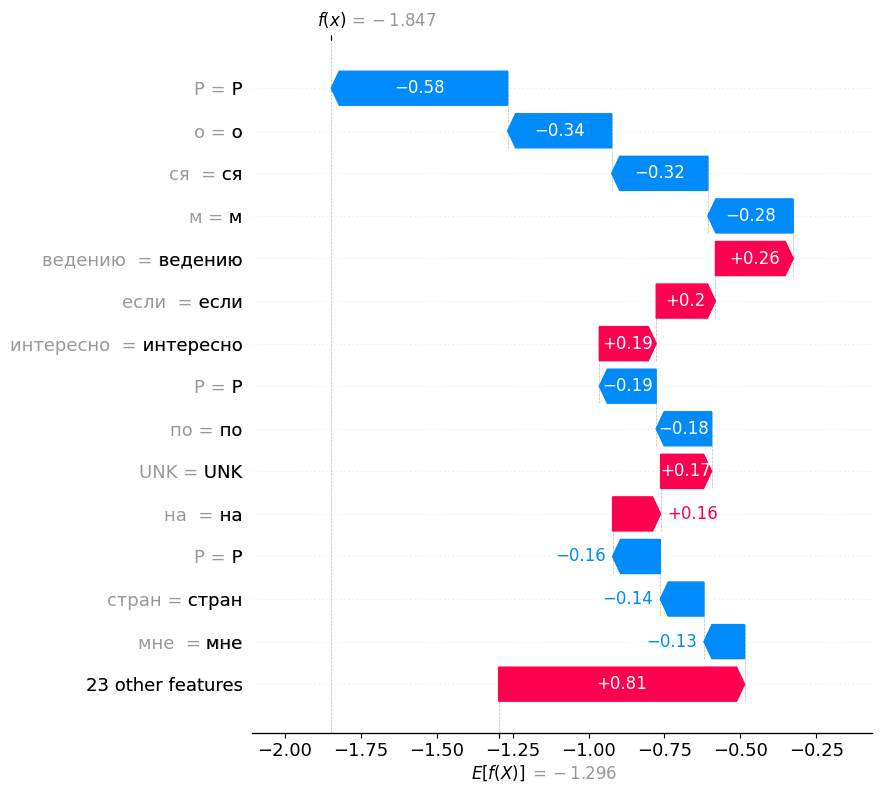

In [37]:
shap.waterfall_plot(shap_values[2][:, 2], max_display=15)